# Import

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from glob import glob
import json
from sys import getsizeof

# Config

In [2]:
class CFG:
    running_locally = False
    running_on_test = None

    debuggin = False

    do_saving_of_res_imgs = True
    do_saving_of_masks = True
    do_saving_of_res_masks=True
    do_saving_of_df = True
    do_display = True
    
    resized_img_shape=(1024,1024)
    resized_msk_shape=(1024,1024)

### Set File Paths

In [3]:
if CFG.running_locally:
    competition_data_dir = '../data/hubmap-organ-segmentation'
    data_dir = '../data'
else:
    competition_data_dir = '/kaggle/input/hubmap-organ-segmentation'
    data_dir = '/kaggle/working'

train_images_dir = f'{competition_data_dir}/train_images'
test_images_dir = f'{competition_data_dir}/test_images'
train_annotations_dir = f'{competition_data_dir}/train_annotations'

train_csv_path = f'{competition_data_dir}/train.csv'
test_csv_path = f'{competition_data_dir}/test.csv'
sample_subm_csv_path = f'{competition_data_dir}/sample_submission.csv'

In [4]:
def load_train_df():
    return pd.read_csv(train_csv_path)

def load_test_df():
    return pd.read_csv(test_csv_path)

### Set running env

In [5]:
# Competition setup related. Sample submission file was len 1 when running on public set.

sample_subm_df = pd.read_csv(sample_subm_csv_path)
if len(sample_subm_df) > 1:
    CFG.running_on_test_set = True
else:
    CFG.running_on_test_set = False
del sample_subm_df

# Add file paths

## Train

In [6]:
image_paths = glob(f'{train_images_dir}/*',recursive=True)

In [7]:
train_df = load_train_df()

In [8]:
print(train_df.shape)

(351, 10)


In [9]:
def add_img_paths_to_df(df, image_paths):
    image_paths_dic = {}
    for i_path in image_paths:
        splitted = i_path.split('/')[-1].split('.')
        assert splitted[1] == 'tiff'
        id = int(splitted[0])
        if id in image_paths_dic:
            raise Exception(f'Duplicate id found {id}')
        else:
            image_paths_dic[id] = i_path

    assert 'int' in str(train_df.id.dtype)
    df['img_path'] = df.id.apply(lambda id: image_paths_dic[id])
    assert train_df.img_path.isna().any() == False
    
    return df

In [10]:
train_df = add_img_paths_to_df(train_df, image_paths)

In [11]:
def add_annot_paths_to_df(df, paths, new_col_name='ann_paths'):
    paths_dic = {}
    for i_path in paths:
        splitted = i_path.split('/')[-1].split('.')
        assert splitted[1] == 'json'
        id = int(splitted[0])
        if id in paths_dic:
            raise Exception(f'Duplicate id found {id}')
        else:
            paths_dic[id] = i_path

    assert 'int' in str(train_df.id.dtype)
    df[new_col_name] = df.id.apply(lambda id: paths_dic[id])
    assert train_df[new_col_name].isna().any() == False
    
    return df

In [12]:
annotation_paths = glob(f'{train_annotations_dir}/*',recursive=True)

In [13]:
train_df = add_annot_paths_to_df(train_df, annotation_paths, new_col_name='ann_paths')

In [14]:
print(getsizeof(train_df)//1e6, 'MB')

16.0 MB


In [15]:
if CFG.do_saving_of_df:
    train_df.to_pickle(f'{data_dir}/train_df.pkl')

In [16]:
print(train_df.shape)
train_df.head()

(351, 12)


id     organ data_source  img_height  img_width  pixel_size  \
0  10044  prostate         HPA        3000       3000         0.4   
1  10274  prostate         HPA        3000       3000         0.4   
2  10392    spleen         HPA        3000       3000         0.4   
3  10488      lung         HPA        3000       3000         0.4   
4  10610    spleen         HPA        3000       3000         0.4   

   tissue_thickness                                                rle   age  \
0                 4  1459676 77 1462675 82 1465674 87 1468673 92 14...  37.0   
1                 4  715707 2 718705 8 721703 11 724701 18 727692 3...  76.0   
2                 4  1228631 20 1231629 24 1234624 40 1237623 47 12...  82.0   
3                 4  3446519 15 3449517 17 3452514 20 3455510 24 34...  78.0   
4                 4  478925 68 481909 87 484893 105 487863 154 4908...  21.0   

      sex                                           img_path  \
0    Male  /kaggle/input/hubmap-organ-segmentation/train_...   
1    Male  /kaggle/input/hubmap-organ-segmentation/train_...   
2    Male  /kaggle/input/hubmap-organ-segmentation/train_...   
3    Male  /kaggle/input/hubmap-organ-segmentation/train_...   
4  Female  /kaggle/input/hubmap-organ-segmentation/train_...   

                                           ann_paths  
0  /kaggle/input/hubmap-organ-segmentation/train_...  
1  /kaggle/input/hubmap-organ-segmentation/train_...  
2  /kaggle/input/hubmap-organ-segmentation/train_...  
3  /kaggle/input/hubmap-organ-segmentation/train_...  
4  /kaggle/input/hubmap-organ-segmentation/train_...

# Drawing

In [17]:
def generate_mask(mask_shape, segmentation_column, drawing_value=1, save_as_int=True):
    if save_as_int:
        mask_type = np.uint8
    else:
        mask_type = np.float32
        drawing_value = 1.0
        
    if len(segmentation_column) == 0:
        return np.zeros(mask_shape, dtype=mask_type)
    else:
        h = mask_shape[0]
        w = mask_shape[1]
        mask_img = np.zeros(h*w, dtype=mask_type)
        segmentation_info = segmentation_column.split(' ')
        if len(segmentation_info) % 2 != 0:
            raise Exception('Segmentation\'s length is not divisible by 2.')
        for i in range(len(segmentation_info) // 2):
            segm_position = int(segmentation_info[i*2])
            segm_len = int(segmentation_info[i*2+1])

            for j in range(segm_len):
                mask_img[segm_position+j] = drawing_value

        return mask_img.reshape((h,w)).T

In [18]:
def load_img(path):
    return cv2.imread(path, flags=cv2.IMREAD_UNCHANGED)

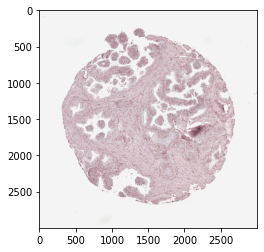

In [19]:
if CFG.do_display:
    img = load_img(train_df.iloc[10].img_path)
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.show()

In [20]:
def add_red_mask(on_img, mask_img):
    assert len(on_img.shape) == 3

    on_img = on_img.astype(np.int16)
    on_img[:,:,0] = np.clip(on_img[:,:,0] + mask_img, 0, 255)

    return on_img.astype(np.uint8)

In [21]:
def draw_msk_over_img(img, msk):
    assert img.shape[2] == 3
    assert len(msk.shape) == 2

    img_to_show = add_red_mask(img, msk)
    return img_to_show

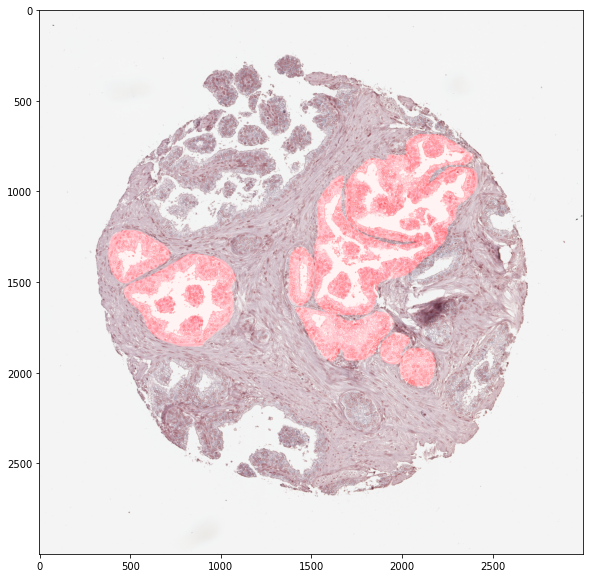

In [22]:
if CFG.do_display:
    row = train_df.iloc[10]
    msk = generate_mask((row.img_height, row.img_width), row.rle, drawing_value=100, save_as_int=True)
    img = cv2.imread(row.img_path, flags=cv2.IMREAD_UNCHANGED)

    img = draw_msk_over_img(img, msk)
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.show()

In [23]:
def plot_multiple_images(imgs, rows_num=3, cols_num=4, img_size=4, no_axis_info=False):
    num_imgs_to_plot = min(len(imgs), rows_num*cols_num)
    rows_num = round(num_imgs_to_plot / cols_num + 0.5)
    plt.figure(figsize=(img_size * cols_num + 2, img_size * rows_num + 2))
    for i in range(num_imgs_to_plot):

        plt.subplot(rows_num, cols_num, i+1)
        plt.imshow(imgs[i])
        if no_axis_info: plt.axis('off') # remove axis info

    plt.tight_layout()
    plt.show()

# Generate Masks

## Original size masks

### create masks directory

In [24]:
masks_dir = os.path.join(data_dir, 'masks')

if CFG.do_saving_of_masks:
    print('Making directory for masks')
    print(os.listdir(data_dir))

    if os.path.exists(masks_dir):
        print('Mask directory already exist')
    else:
        os.mkdir(masks_dir)
        print(os.listdir(data_dir))

Making directory for masks
['.virtual_documents', 'train_df.pkl', '__notebook_source__.ipynb']
['.virtual_documents', 'train_df.pkl', 'masks', '__notebook_source__.ipynb']


### add mask_path column to train and test 

In [25]:
mask_path_col = 'mask_path'

In [26]:
def create_masks_np_from_path(id, root_dir=masks_dir):
    return f'{root_dir}/{id}.npy'
    # return file_path.replace('train', 'masks_singular/stomach').replace('png', 'npy')

train_df[mask_path_col] = train_df.id.apply(create_masks_np_from_path)
# test_df[mask_path_col] = test_df.id.apply(create_masks_np_from_path)

### Save all masks

In [27]:
def save_mask_as_int(mask, mask_path):
    assert mask.dtype==np.uint8

    np.save(mask_path, mask)

def save_mask_as_float(mask, mask_path):
    assert mask.dtype==np.float32

    np.save(mask_path, mask)

In [28]:
if CFG.do_saving_of_masks:
    print('Masks amount:', len(train_df))
    try:
        for i, (df_index, df_row) in enumerate(train_df.iterrows()):
            if i%10 == 0: print(f'\r {i}', end='')
                    
            h = int(df_row.img_height)
            w = int(df_row.img_width)
            mask_img = generate_mask((h,w), df_row.rle, drawing_value=1 ,save_as_int=True)
            save_mask_as_int(mask_img, df_row[mask_path_col])
        print()
    except Exception as e:
        print(e)
        print('Error', i, df_index, df_row.id)
    
    print(f'\r {i}')

Masks amount: 351
 350
 350


In [29]:
if CFG.do_saving_of_df:
    train_df.to_pickle(f'{data_dir}/train_df.pkl')

### Check masks

In [30]:
train_df = pd.read_pickle(f'{data_dir}/train_df.pkl')

In [31]:
train_df.columns

Index(['id', 'organ', 'data_source', 'img_height', 'img_width', 'pixel_size',
       'tissue_thickness', 'rle', 'age', 'sex', 'img_path', 'ann_paths',
       'mask_path'],
      dtype='object')

In [32]:
def load_mask(mask_path_np, return_float=False):
    mask_img = np.load(mask_path_np)
    if return_float:
        return mask_img.astype(np.float32) / 255.0
    else:
        return mask_img

In [33]:
img_sizes = []
for mp in train_df[mask_path_col].values:
    img_sizes.append(os.path.getsize(mp))

In [34]:
print(f'Img sizes sum: {sum(img_sizes) / 1e9:.2}GB')
print(f'Img sizes average: {np.mean(img_sizes) / 1e6:.2}MB')
print(f'Num images: {len(img_sizes)}')

Img sizes sum: 3.1GB
Img sizes average: 8.9MB
Num images: 351


### Plot masks

/kaggle/working/masks/10044.npy


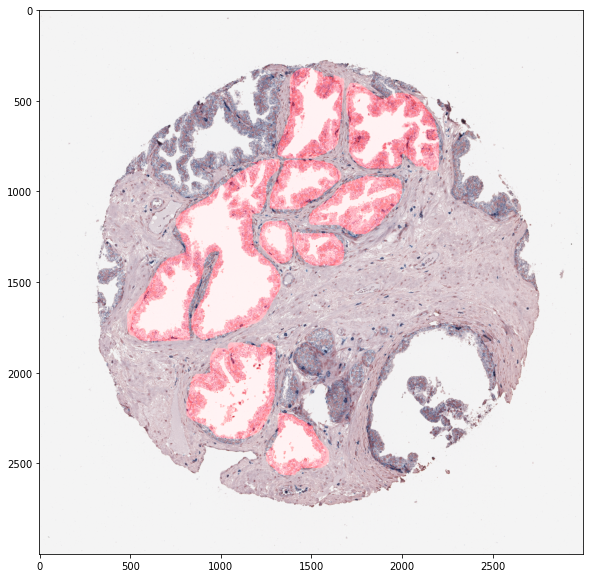

In [65]:
if CFG.do_display:
    r = train_df.iloc[0]
    print(r.mask_path)

    img = load_img(r.img_path)
    msk = load_mask(r.mask_path)
    
    img_to_show = draw_msk_over_img(img, msk*100)
    plt.figure(figsize=(10,10))
    plt.imshow(img_to_show)
    plt.show()

In [36]:
def plot_multiple_images(imgs, rows_num=3, cols_num=4, img_size=4, no_axis_info=False):
    num_imgs_to_plot = min(len(imgs), rows_num*cols_num)
    rows_num = round(num_imgs_to_plot / cols_num + 0.5)
    plt.figure(figsize=(img_size * cols_num + 2, img_size * rows_num + 2))
    for i in range(num_imgs_to_plot):

        plt.subplot(rows_num, cols_num, i+1)
        plt.imshow(imgs[i])
        if no_axis_info: plt.axis('off') # remove axis info

    plt.tight_layout()
    plt.show()

Plot:


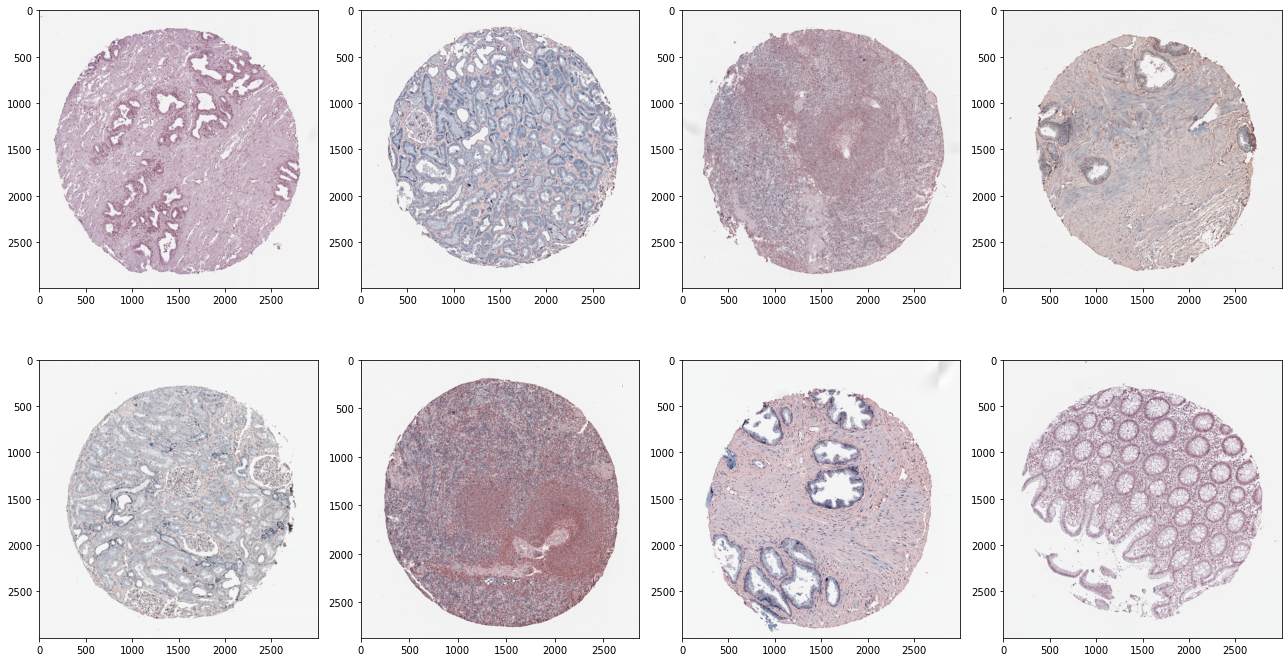

In [37]:
if CFG.do_display:
    imgs_to_plot = []
    for df_index, df_row in train_df.sample(12).iterrows():

        img = load_img(df_row.img_path)
        msk = load_mask(df_row.mask_path)
        
        imgs_to_plot.append(draw_msk_over_img(img, msk))

    print('Plot:')
    plot_multiple_images(imgs_to_plot, rows_num=2)

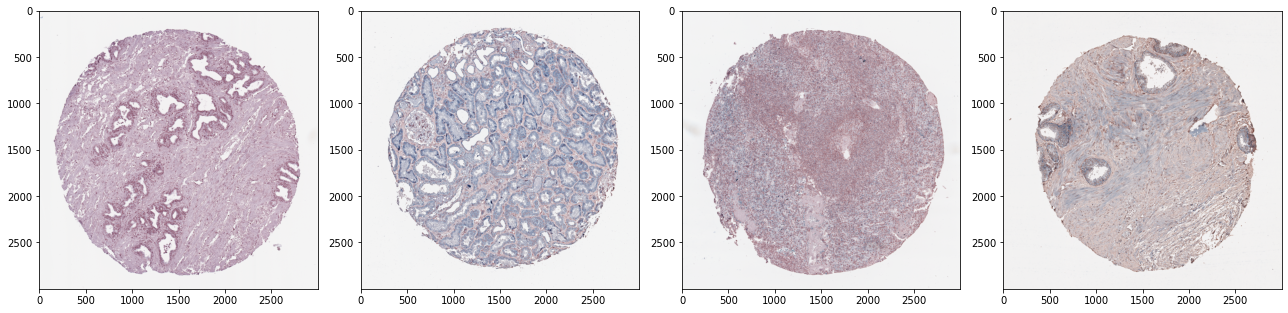

In [38]:
if CFG.do_display:
    plot_multiple_images(imgs_to_plot, rows_num=1)

## Resize masks

In [40]:
resized_msk_shape = CFG.resized_msk_shape

In [41]:
resized_masks_dir = os.path.join(data_dir, 'resized_masks')

if CFG.do_saving_of_res_masks:
    print('Making directory for masks')
    print(os.listdir(data_dir))

    if os.path.exists(resized_masks_dir):
        print('Mask directory already exist')
    else:
        os.mkdir(resized_masks_dir)
        print(os.listdir(data_dir))

Making directory for masks
['.virtual_documents', 'train_df.pkl', 'masks', '__notebook_source__.ipynb']
['.virtual_documents', 'resized_masks', 'train_df.pkl', 'masks', '__notebook_source__.ipynb']


### New path

In [42]:
resized_mask_path_col = 'resized_mask_path'

In [43]:
def create_masks_np_from_path(id, root_dir=resized_masks_dir):
    return f'{root_dir}/{id}.npy'

train_df[resized_mask_path_col] = train_df.id.apply(create_masks_np_from_path)

### Save all

In [44]:
def resize_img(img, new_shape):
    return cv2.resize(img, dsize=new_shape, interpolation = cv2.INTER_AREA)

In [45]:
if CFG.do_saving_of_res_masks:
    for i, (df_index, df_row) in enumerate(train_df.iterrows()):
        if i%10 == 0: print(f'\r {i}', end='')

        msk = load_mask(df_row[mask_path_col])

        resized_msk = resize_img(msk, new_shape=resized_msk_shape)

        save_mask_as_int(resized_msk, df_row[resized_mask_path_col])
    print('\rDone')

Done


### Size check

In [46]:
img_sizes = []
for mp in train_df[resized_mask_path_col].values:
    img_sizes.append(os.path.getsize(mp))

print(f'Img sizes sum: {sum(img_sizes) / 1e9:.2}GB')
print(f'Img sizes average: {np.mean(img_sizes) / 1e6:.2}MB')
print(f'Num images: {len(img_sizes)}')

Img sizes sum: 0.37GB
Img sizes average: 1.0MB
Num images: 351


### Plot

Plot:


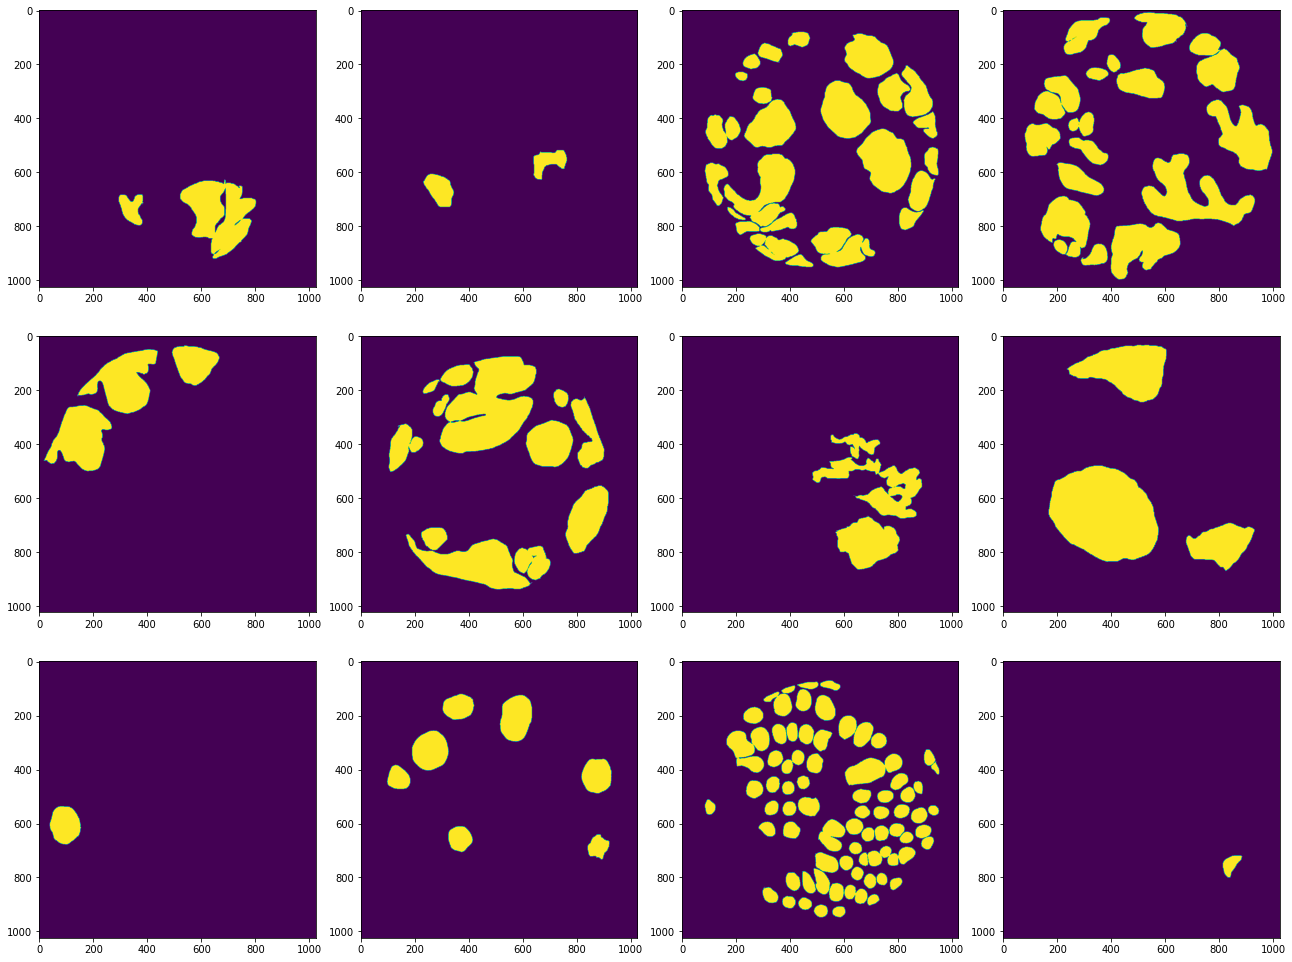

In [47]:
if CFG.do_display:
    imgs_to_plot = []
    for df_index, df_row in train_df.sample(12).iterrows():

        img = load_img(df_row.img_path)
        img = resize_img(img, (resized_msk_shape[0],resized_msk_shape[1]))
        msk = load_mask(df_row[resized_mask_path_col])
        
#         imgs_to_plot.append(draw_msk_over_img(img, msk))
        imgs_to_plot.append(msk)
        

    print('Plot:')
    plot_multiple_images(imgs_to_plot, rows_num=3)

### Save df

In [48]:
if CFG.do_saving_of_df:
    train_df.to_pickle(f'{data_dir}/train_df.pkl')

# Resize imgs

## Resize images

In [49]:
resized_img_shape = CFG.resized_img_shape

In [50]:
resized_imgs_dir = os.path.join(data_dir, 'resized_images')

if CFG.do_saving_of_res_imgs:
    print('Making directory for resized images')
    print(os.listdir(data_dir))

    if os.path.exists(resized_imgs_dir):
        print('Resized images directory already exist')
    else:
        os.mkdir(resized_imgs_dir)
        print(os.listdir(data_dir))

Making directory for resized images
['.virtual_documents', 'resized_masks', 'train_df.pkl', 'masks', '__notebook_source__.ipynb']
['.virtual_documents', 'resized_masks', 'resized_images', 'train_df.pkl', 'masks', '__notebook_source__.ipynb']


### New path

In [51]:
resized_img_path_col = 'resized_img_path'

In [52]:
def create_imgs_np_from_path(id, root_dir=resized_imgs_dir):
    return f'{root_dir}/{id}.npy'

train_df[resized_img_path_col] = train_df.id.apply(create_imgs_np_from_path)

### Save all

In [53]:
def resize_img(img, new_shape):
    return cv2.resize(img, dsize=new_shape, interpolation = cv2.INTER_AREA)

In [54]:
if CFG.do_saving_of_res_imgs:
    for i, (df_index, df_row) in enumerate(train_df.iterrows()):
        if i%10 == 0: print(f'\r {i}', end='')

        img = load_img(df_row['img_path'])

        resized_img = resize_img(img, new_shape=resized_img_shape)

        save_mask_as_int(resized_img, df_row[resized_img_path_col])
    print('\rDone')

Done


### Size check

In [55]:
img_sizes = []
for res_img_path in train_df[resized_img_path_col].values:
    img_sizes.append(os.path.getsize(res_img_path))

print(f'Img sizes sum: {sum(img_sizes) / 1e9:.2}GB')
print(f'Img sizes average: {np.mean(img_sizes) / 1e6:.2}MB')
print(f'Num images: {len(img_sizes)}')

Img sizes sum: 1.1GB
Img sizes average: 3.1MB
Num images: 351


### Plot

Plot:


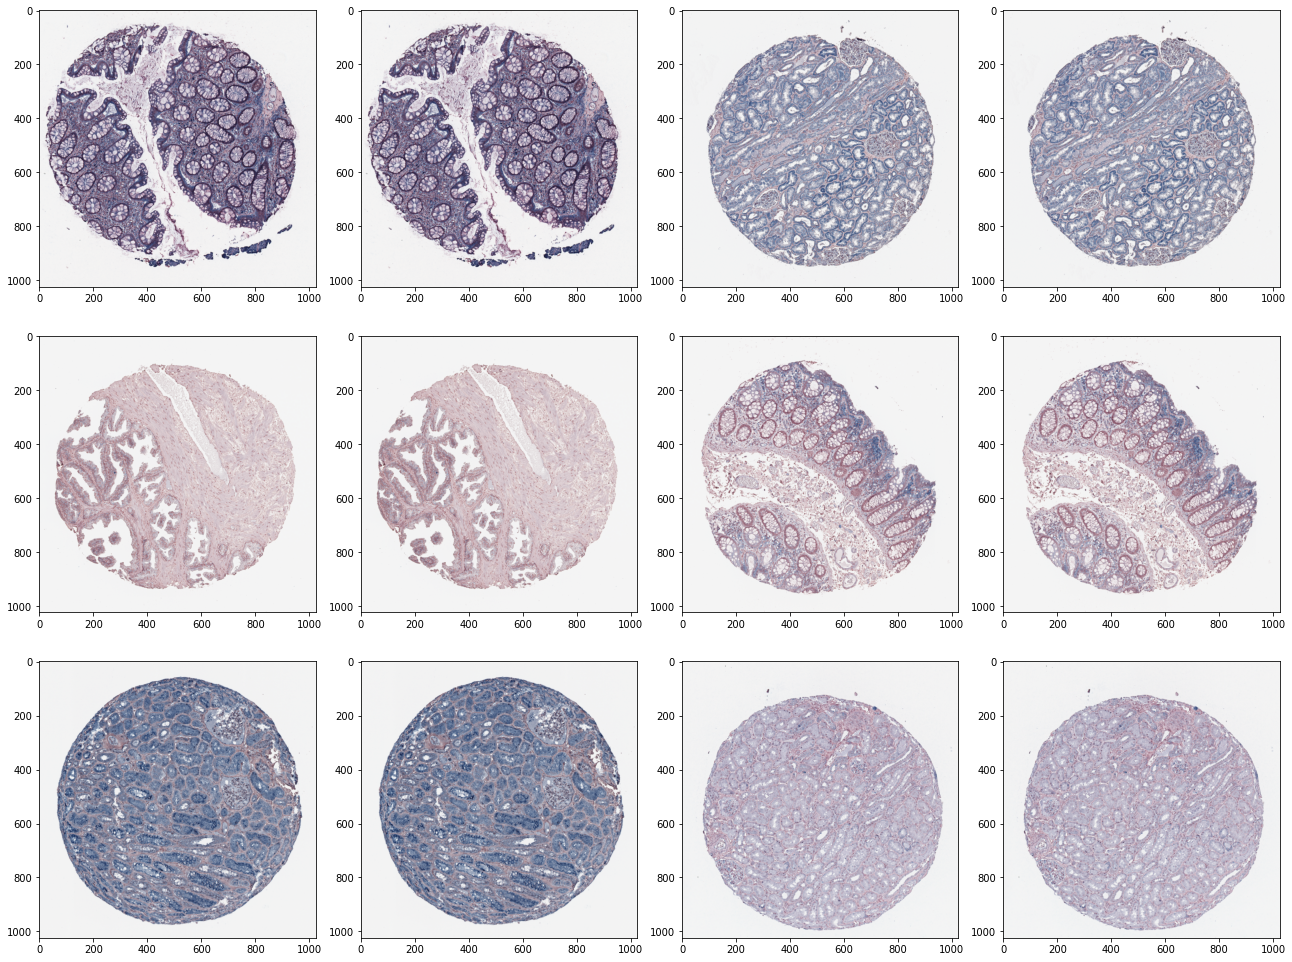

In [56]:
if CFG.do_display:
    imgs_to_plot = []
    for df_index, df_row in train_df.sample(12).iterrows():

        img = load_img(df_row.img_path)
        img = resize_img(img, resized_img_shape)

        res_img = load_mask(df_row[resized_img_path_col])
        
        imgs_to_plot.append(img)
        imgs_to_plot.append(res_img)

    print('Plot:')
    plot_multiple_images(imgs_to_plot, rows_num=3)

### Save df

In [57]:
if CFG.do_saving_of_df:
    train_df.to_pickle(f'{data_dir}/train_df.pkl')

# Done

In [58]:
if not CFG.running_locally:
    !ls -l /kaggle/working/

total 16120
---------- 1 root root      263 Mar 24 17:46 __notebook_source__.ipynb
drwxr-xr-x 2 root root    12288 Mar 24 17:47 masks
drwxr-xr-x 2 root root    12288 Mar 24 17:51 resized_images
drwxr-xr-x 2 root root    12288 Mar 24 17:48 resized_masks
-rw-r--r-- 1 root root 16464180 Mar 24 17:51 train_df.pkl


In [59]:
if not CFG.running_locally:
    !du -cha --max-depth=1 /kaggle/working/ | grep -E "M|G"

353M	/kaggle/working/resized_masks
1.1G	/kaggle/working/resized_images
16M	/kaggle/working/train_df.pkl
3.0G	/kaggle/working/masks
4.3G	/kaggle/working/
4.3G	total


In [60]:
print(train_df.shape)
train_df.head()

(351, 15)


id     organ data_source  img_height  img_width  pixel_size  \
0  10044  prostate         HPA        3000       3000         0.4   
1  10274  prostate         HPA        3000       3000         0.4   
2  10392    spleen         HPA        3000       3000         0.4   
3  10488      lung         HPA        3000       3000         0.4   
4  10610    spleen         HPA        3000       3000         0.4   

   tissue_thickness                                                rle   age  \
0                 4  1459676 77 1462675 82 1465674 87 1468673 92 14...  37.0   
1                 4  715707 2 718705 8 721703 11 724701 18 727692 3...  76.0   
2                 4  1228631 20 1231629 24 1234624 40 1237623 47 12...  82.0   
3                 4  3446519 15 3449517 17 3452514 20 3455510 24 34...  78.0   
4                 4  478925 68 481909 87 484893 105 487863 154 4908...  21.0   

      sex                                           img_path  \
0    Male  /kaggle/input/hubmap-organ-segmentation/train_...   
1    Male  /kaggle/input/hubmap-organ-segmentation/train_...   
2    Male  /kaggle/input/hubmap-organ-segmentation/train_...   
3    Male  /kaggle/input/hubmap-organ-segmentation/train_...   
4  Female  /kaggle/input/hubmap-organ-segmentation/train_...   

                                           ann_paths  \
0  /kaggle/input/hubmap-organ-segmentation/train_...   
1  /kaggle/input/hubmap-organ-segmentation/train_...   
2  /kaggle/input/hubmap-organ-segmentation/train_...   
3  /kaggle/input/hubmap-organ-segmentation/train_...   
4  /kaggle/input/hubmap-organ-segmentation/train_...   

                         mask_path                        resized_mask_path  \
0  /kaggle/working/masks/10044.npy  /kaggle/working/resized_masks/10044.npy   
1  /kaggle/working/masks/10274.npy  /kaggle/working/resized_masks/10274.npy   
2  /kaggle/working/masks/10392.npy  /kaggle/working/resized_masks/10392.npy   
3  /kaggle/working/masks/10488.npy  /kaggle/working/resized_masks/10488.npy   
4  /kaggle/working/masks/10610.npy  /kaggle/working/resized_masks/10610.npy   

                           resized_img_path  
0  /kaggle/working/resized_images/10044.npy  
1  /kaggle/working/resized_images/10274.npy  
2  /kaggle/working/resized_images/10392.npy  
3  /kaggle/working/resized_images/10488.npy  
4  /kaggle/working/resized_images/10610.npy